In [2]:
import os
from standardiser import standardise
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
import numpy as np
import umap
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


DATAPATH = "../data"

/tmp/ipykernel_933/518283421.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
grover = pd.read_csv(os.path.join(DATAPATH, "reference_library.csv"))
coconut = PandasTools.LoadSDF(os.path.join(DATAPATH, "COCONUT_DB.SDF"))

[14:35:49] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:35:49] ERROR: Could not sanitize molecule ending on line 53
[14:35:49] ERROR: Explicit valence for atom # 20 C, 6, is greater than permitted
[14:35:51] Explicit valence for atom # 3 B, 4, is greater than permitted
[14:35:51] ERROR: Could not sanitize molecule ending on line 329955
[14:35:51] ERROR: Explicit valence for atom # 3 B, 4, is greater than permitted
[14:35:55] ERROR: EOF hit while reading atoms
[14:35:55] ERROR: moving to the beginning of the next molecule
Failed to patch pandas - unable to change molecule rendering


In [4]:
def is_processable_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return True
        else:
            return False
    except Exception as e:
        print("Error:", e)
        return False

In [5]:
def get_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        # Generate InChIKey
        inchi_key = Chem.InchiToInchiKey(Chem.MolToInchi(mol))

        return inchi_key

In [6]:
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        # Generate canonical SMILES
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=False)

        return canonical_smiles

In [7]:
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        try:
            mol = standardise.run(mol)  # standardise.run expects a list of molecules
        except:
            mol = None

    if mol is not None:
        smiles_standard = Chem.MolToSmiles(mol)
    else:
        smiles_standard = None
        
    return smiles_standard

# Data gotten from Grover

In [8]:
grover['validate_smiles'] = grover['smiles'].apply(lambda x: is_processable_smiles(x))
grover[grover['validate_smiles']]

[14:37:37] WARNING: not removing hydrogen atom without neighbors
[14:37:50] WARNING: not removing hydrogen atom without neighbors
[14:37:58] WARNING: not removing hydrogen atom without neighbors


,smiles,validate_smiles
0,COC(=O)C1=CC=CC2=C1C(=O)C1=CC([N+](=O)[O-])=CC...,True
1,CN(C)CCC1=CN(C)C2=CC=C(O)C=C12,True
2,CC1=C(S(=O)(=O)N2CCCCC2)C2=C(S1)N=CN(CC(=O)N1C...,True
3,CN(C)CCOC1=CC=C(C(=O)/C=C/C2=CC=C(OC3=CC=CC=C3...,True
4,O=C(CCC1=COC2=CC=CC(OCC3CCCCC3)=C2C1=O)C1=CC=C...,True
...,...,...
1999376,CCOC(=O)C1=CC=C(NC(=O)C2=C(C(=O)NC3CCN(C(=O)OC...,True
1999377,CC(C)N1C=NN=C1C1CCCN(C(=O)COCC2=CC=CC=C2)C1,True
1999378,C[C@H]1CCC2=CC(C3=NC4=CC=C(Cl)C=C4C=C3CO)=CC=C...,True
1999379,COC(=O)C1C(O)=C2C(=NC3=CC=CC=C3NC2C2=CC=CS2)CC1C,True


In [9]:
# Randomly choose 800 SMILES
sampled_df = grover.sample(n=1000, random_state=42)

In [10]:
# Apply the canonical_smiles function to obtain their canonical smiles
grover_smiles = sampled_df.apply(lambda row: pd.Series(canonical_smiles(row['smiles']), index=['Canonical_SMILES']), axis=1)
grover = pd.concat([sampled_df, grover_smiles], axis=1)
#Standardise the smiles
grover['Standardized_SMILES'] = grover['Canonical_SMILES'].apply(standardize_smiles)
grover_cleaned = grover.dropna()
print(grover_cleaned)

[14:40:45] Can't kekulize mol.  Unkekulized atoms: 3 6


                                                    smiles  validate_smiles  \
846624                        CCCCNC(=S)N/N=C/C1=C(C)C=CS1             True   
827633          CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1             True   
985460            O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl             True   
1341588  O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...             True   
611367   CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...             True   
...                                                    ...              ...   
404816   CCCN1C(C2=CN=C(NC3=CC=C(C)N=C3)C(Cl)=C2)=NC2=C...             True   
224301    CN(CC1=CC=CC2=CC=CC=C12)CN1N=C(C2=CC=NC=C2)OC1=O             True   
105421   O=C(N[C@@H](CSCC1=CC=CC=C1)C(=O)NC1=CC=C(C2S/C...             True   
174191   CN1CC[C@]23CCCC[C@H]2[C@H]1CC1=CC=C(OC2=CC=CC=...             True   
1019290  O=C(CN1C(=O)/C(=C/C2=CC=CO2)SC1=S)NC1=CC=C(C(=...             True   

                                          Canonical

In [11]:
grover = grover_cleaned.sample(n=800, random_state=42)
grover.drop(columns=['validate_smiles'], inplace=True)
grover_smiles = grover.apply(lambda row: pd.Series(get_inchikey(row['smiles']), index=['InChIKey']), axis=1)
grover = pd.concat([grover, grover_smiles], axis=1)
grover['Data'] = 'Grover'

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Charges were rearranged

[14:40:46] WARNING: Charges were rearranged

[14:40:46] WARNING: Charges were rearranged; Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Proton(s) added/removed

[14:40:46] WARNING: Proton(s) added/removed

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Charges were rearranged

[14:40:46] WARNING: Charges were rearranged

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Charges were rearranged; Omitted undefined stereo

[14:40:46] WARNING: Omitted undefined stereo

[14:40:46] WARNING: Charges were rearranged

[14:40:46] WARNING: Omitted undefined

In [12]:
grover
grover.to_csv(os.path.join(DATAPATH, 'grover.csv'), index=False)

# Data gotten from Coconut

In [13]:
coconut.rename(columns={'inchikey': 'InChIKey'}, inplace=True)
coconut.rename(columns={'SMILES': 'smiles'}, inplace=True)
coconut['validate_smiles'] = coconut['smiles'].apply(lambda x: is_processable_smiles(x))
coconut[coconut['validate_smiles']]

,coconut_id,inchi,InChIKey,smiles,sugar_free_smiles,molecular_formula,molecular_weight,citationDOI,textTaxa,name,...,total_atom_number,bond_count,found_in_databases,murko_framework,alogp,apol,topoPSA,ID,ROMol,validate_smiles
1,CNP0000002,InChI=1S/C27H36N2O15S/c1-5-12(29-9-45)26(37)44...,FJEMIESGEMWDOB-UHFFFAOYSA-N,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,O=C(O)C=1C(=O)C(O)CC(=O)C1N,C27H36N2O15S,660.6463016716552,[],[notax],5-{6-[(acetyloxy)methyl]-3-hydroxy-4-[(5-hydro...,...,81,47,[chemspidernp],C1=CCCCC1,-2.4338000000000015,88.65454800000002,298.83,,<rdkit.Chem.rdchem.Mol object at 0x7ff1d1b9cc10>,True
2,CNP0000003,InChI=1S/C34H30O10/c1-14-10-16-24(21(11-14)42-...,KLWKJVYCDFWQMK-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,C34H30O10,598.5972923812595,[],[notax],"20,30-dihydroxy-5,9,12,25-tetramethoxy-27-meth...",...,74,50,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.027099999999997695,87.86379000000002,137.82,,<rdkit.Chem.rdchem.Mol object at 0x7ff1d1b9cc80>,True
3,CNP0000004,InChI=1S/C32H26O9/c1-13-9-16-24(20(10-13)39-2)...,PTEKHLCNKCAXPH-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,C32H26O9,554.5446526448111,[],[notax],"9,20,30-trihydroxy-5,25-dimethoxy-27-methyl-22...",...,67,47,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.4611999999999999,80.874618,139.59,,<rdkit.Chem.rdchem.Mol object at 0x7ff1d1b9ccf0>,True
4,CNP0000005,"InChI=1S/C33H42O6/c1-31(2,3)30(36)37-18-17-33(...",ZVAVQCZAGOKAMX-UHFFFAOYSA-N,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,C33H42O6,534.6842258201034,[],[notax],"5-(benzoyloxy)-7-{2-[(2,2-dimethylpropanoyl)ox...",...,81,42,[chemspidernp],O(Cc1ccccc1)C2CCC3CCCC3C2OCc4ccccc4,6.415000000000001,90.89730600000003,78.9,,<rdkit.Chem.rdchem.Mol object at 0x7ff1d1b9cd60>,True
5,CNP0000006,InChI=1S/C31H24O9/c1-12-8-15-23(20(9-12)39-2)3...,UYIPOCQHTAYRMA-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,C31H24O9,540.5180352403714,[],[notax],"5,9,20,30-tetrahydroxy-25-methoxy-27-methyl-22...",...,64,46,[chemspidernp],O1Cc2ccccc2CC34Cc5ccc6c(c5C4C=CCC13)Cc7ccccc7C6,0.39670000000000016,77.78103199999998,150.59,,<rdkit.Chem.rdchem.Mol object at 0x7ff1d1b9cdd0>,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,CNP0009242,InChI=1S/C46H54N2O16/c1-23(2)13-30-39-28(17-36...,KVLJKHLZKMFYMZ-UHFFFAOYSA-N,O=C(O)C1C#CCC(NC)C(N)COC2OC(COC1=O)C(OCCCO)C(O...,O=C(O)C1C#CCC(NC)C(N)COC2OC(COC1=O)C(OCCCO)C(O...,C46H54N2O16,890.9265372140226,[],[notax],4-amino-15-hydroxy-16-({16-[(3-hydroxyphenyl)m...,...,118,71,[zincnp],C1#CCCCCOC2OC(COCC1)CCC2OOc3cc4c(OCC5c6cc7OCOc...,0.6736,131.99882200000008,245.4099999999999,,<rdkit.Chem.rdchem.Mol object at 0x7ff1dfc4c3c0>,True
8140,CNP0009243,"InChI=1S/C53H72N6O10S/c1-54-32-57-53(68,50(66)...",UFWOQVKVTVELFR-UHFFFAOYSA-N,O=C(O)C(O)NC(=O)C(NC(=O)CCC(O)(NCNC)C(=O)O)CSC...,O=C(O)C(O)NC(=O)C(NC(=O)CCC(O)(NCNC)C(=O)O)CSC...,C53H72N6O10S,985.2410903161685,[],[notax],4-({2-[13'-(3-benzylpiperidin-2-yl)-11'-oxo-14...,...,142,77,[zincnp],n1ccc(cc1)CC2=C(C3C4=C(OC3)CC5(CCCC5)CCCCC6(CC...,4.685700000000002,158.809096,273.30999999999995,,<rdkit.Chem.rdchem.Mol object at 0x7ff1dfc4c430>,True
8141,CNP0009244,"InChI=1S/C55H72N6O10S/c1-56-32-59-55(70,52(68)...",QDGUFCBLIMZQTO-UHFFFAOYSA-N,O=C(O)C(O)NC(=O)C(NC(=O)CCC(O)(NCNC)C(=O)O)CSC...,O=C(O)C(O)NC(=O)C(NC(=O)CCC(O)(NCNC)C(=O)O)CSC...,C55H72N6O10S,1009.2625621097445,[],[notax],"4-{[2-(13'-{5-azatricyclo[9.4.0.0³,⁸]pentadeca...",...,144,80,[zincnp],n1ccc(cc1)CC2=C(C3C4=C(OC3)CC5(CCCCCC4C26CCCC6...,4.567699999999997,162.32909599999996,273.30999999999995,,<rdkit.Chem.rdchem.Mol object at 0x7ff1dfc4c4a0>,True
8142,CNP0009251,InChI=1S/C52H58O11/c1-32(2)40-20-19-33-13-15-3...,XOZCFTVWWYJDPX-UHFFFAOYSA-N,O=C1OC2=C(C=CC=

In [14]:
coconut = coconut[['InChIKey', 'smiles', 'molecular_weight']]
coconut
coconut.to_csv(os.path.join(DATAPATH, 'coconut_data.csv'), index=False)

In [15]:
data = pd.read_csv(os.path.join(DATAPATH, "coconut_data.csv"))

In [16]:
data['molecular_weight'] = data['molecular_weight'].astype(float)
filtered_data = data[data['molecular_weight'] <= 800]
filtered_data['validate_smiles'] = filtered_data['smiles'].apply(lambda x: is_processable_smiles(x))
data = filtered_data.apply(lambda row: pd.Series(canonical_smiles(row['smiles']), index=['Canonical_SMILES']), axis=1)
coconut = pd.concat([data, filtered_data], axis=1)
coconut

/tmp/ipykernel_933/3784642488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['validate_smiles'] = filtered_data['smiles'].apply(lambda x: is_processable_smiles(x))


,Canonical_SMILES,InChIKey,smiles,molecular_weight,validate_smiles
0,CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...,FJEMIESGEMWDOB-UHFFFAOYSA-N,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,660.646302,True
1,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,KLWKJVYCDFWQMK-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,598.597292,True
2,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...,PTEKHLCNKCAXPH-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,554.544653,True
3,CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...,ZVAVQCZAGOKAMX-UHFFFAOYSA-N,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,534.684226,True
4,COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...,UYIPOCQHTAYRMA-UHFFFAOYSA-N,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,540.518035,True
...,...,...,...,...,...
8115,CC(=O)OC1CCc2cc(c(O)c(OC3CCCC3)c2)CN2CC(Cc3ccn...,HUEMZWCZVCMVSA-UHFFFAOYSA-N,O=C(OC1CCC2=CC(OC3CCCC3)=C(O)C(=C2)CN4C(=O)CC(...,771.048082,True
8120,COc1cccc(CNC2(Cc3cc(COc4ccccc4)on3)COC2)c1,RVEFIHAWTHZDEF-UHFFFAOYSA-N,N=1OC(=CC1CC2(NCC=3C=CC=C(OC)C3)COC2)COC=4C=CC...,380.437794,True
8121,CC(C)N1CC2OCC(=O)N(Cc3ccccn3)C2C1,AIORHJYCQSQXJT-UHFFFAOYSA-N,O=C1N(CC2=NC=CC=C2)C3CN(CC3OC1)C(C)C,275.346714,True
8123,CCCCCC=CC(=O)CCc1ccc(O)c(OCCc2ccc(O)c(C3c4cc5c...,WDZUGAIOENTRRM-UHFFFAOYSA-N,O=C(C=CCCCCC)CCC1=CC=C(O)C(OCCC2=CC=C(O)C(=C2)...,672.833317,True


In [17]:
coconut['Standardized_SMILES'] = coconut['Canonical_SMILES'].apply(standardize_smiles)
coconut_cleaned = coconut.dropna()
print(coconut_cleaned)

[14:40:53] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7
[14:40:53] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7
[14:40:53] Can't kekulize mol.  Unkekulized atoms: 3 7 8 9
[14:40:53] Can't kekulize mol.  Unkekulized atoms: 3 7 8 9
[14:40:53] Can't kekulize mol.  Unkekulized atoms: 3 6 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9
[14:40:54] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 9
[14:40:54] Can't kek

                                       Canonical_SMILES  \
0     CC=C(N=CS)C(=O)OC1C(COC(C)=O)OC(C2(O)CC(=O)C(N...   
1     COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...   
2     COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(OC)c5c4C...   
3     CC1(C)CC2C(OC(=O)c3ccccc3)C(OC(=O)c3ccccc3)CC(...   
4     COc1cc(C)cc2c1C(=O)OC1C(O)C=CC3c4c(cc(O)c5c4C(...   
...                                                 ...   
8115  CC(=O)OC1CCc2cc(c(O)c(OC3CCCC3)c2)CN2CC(Cc3ccn...   
8120         COc1cccc(CNC2(Cc3cc(COc4ccccc4)on3)COC2)c1   
8121                  CC(C)N1CC2OCC(=O)N(Cc3ccccn3)C2C1   
8123  CCCCCC=CC(=O)CCc1ccc(O)c(OCCc2ccc(O)c(C3c4cc5c...   
8131  CCc1ccc2ccccc2c1C1C=CC(C(Cc2cnc[cH-]2)C(O)CC(=...   

                         InChIKey  \
0     FJEMIESGEMWDOB-UHFFFAOYSA-N   
1     KLWKJVYCDFWQMK-UHFFFAOYSA-N   
2     PTEKHLCNKCAXPH-UHFFFAOYSA-N   
3     ZVAVQCZAGOKAMX-UHFFFAOYSA-N   
4     UYIPOCQHTAYRMA-UHFFFAOYSA-N   
...                           ...   
8115  HUEMZWCZVCMVSA-UHFFFAOYSA-

In [18]:
coconut_200 = coconut.sample(n=200, random_state=42)
coconut_200['Data'] = 'Coconut'
coconut_200.to_csv(os.path.join(DATAPATH, 'coconut_processed200.csv'), index=False)

# Combining both datasets together and plotting the UMAP and PCA

In [19]:
combined_df = pd.concat([grover, coconut_200], ignore_index=True)
combined_df.drop(columns=combined_df[['validate_smiles', 'molecular_weight']], inplace=True)
combined_df.to_csv(os.path.join(DATAPATH, 'Validations.csv'), index=False)
combined_df

,smiles,Canonical_SMILES,Standardized_SMILES,InChIKey,Data
0,OC1=CC=C(O)C(C2CCCCCCC2)=C1,Oc1ccc(O)c(C2CCCCCCC2)c1,Oc1ccc(O)c(C2CCCCCCC2)c1,OCFACRWFEFGYDB-UHFFFAOYSA-N,Grover
1,CC1(C)NC(=O)N(CCC2=CC=CC=C2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,HMBAGIWVHSMZGN-UHFFFAOYSA-N,Grover
2,N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@H]1CSSC[C@@H]...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,LYNBJSJVJXRVTC-BZSNNMDCSA-N,Grover
3,CCCCN(C)C(=O)C1=CC=C2C(=C1)C1=C(N2S(=O)(=O)CC)...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,OZLHJBSTXWDJKT-UHFFFAOYSA-N,Grover
4,CN(CCCN1C(=O)[C@@H]2CC3=CC=CC=C3CN2C1=O)C1=CC=...,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,YUSCAAHQWLTSSG-IBGZPJMESA-N,Grover
...,...,...,...,...,...
995,O=C(CC(O)C(CC1=CC=C(O)C(OC)=C1)CC2=CN=C[CH-]2)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,JAXXZEZANJBBNX-UHFFFAOYSA-N,Coconut
996,FC(F)(F)OC1=CC=C(C=C1)CNC2(COC2)CC3=NOC(=C3)CN...,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,OVMXRKCLUWORMI-UHFFFAOYSA-N,Coconut
997,O=C1N(C(=O)C2(N3CC(O)CC13)CN(C2)CC(C)(C)C)CCCC,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,IBDFZRSTGPAVHK-UHFFFAOYSA-N,Coconut
998,O=C(CC(O)C(CC1=CN=C[CH-]1)C2C=CC(C3=C(OC)C(O)=...,CCc1ccc2ccccc2c1C1C=CC(C(Cc2cnc[cH-]2)C(O)CC(=...,CCc1ccc2ccccc2c1C1C=CC(C(CC2=CN=CC2)C(O)CC(=O)...,YSPBAEVAURFGFM-UHFFFAOYSA-N,Coconut


In [20]:
smiles = combined_df['Standardized_SMILES']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
# Filter out None molecules
valid_mols = [mol for mol in mols if mol is not None]

# Specify the radius and number of bits for Morgan fingerprint
radius = 3
nBits = 2048

# Generate Morgan fingerprints for valid molecules
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in valid_mols]
morgan_fps_train = [np.array(list(fp.ToBitString())).astype(int) for fp in fps]


In [21]:
morgan_fps_train
combined_df['Fingerprints'] = morgan_fps_train
combined_df

,smiles,Canonical_SMILES,Standardized_SMILES,InChIKey,Data,Fingerprints
0,OC1=CC=C(O)C(C2CCCCCCC2)=C1,Oc1ccc(O)c(C2CCCCCCC2)c1,Oc1ccc(O)c(C2CCCCCCC2)c1,OCFACRWFEFGYDB-UHFFFAOYSA-N,Grover,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC1(C)NC(=O)N(CCC2=CC=CC=C2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,CC1(C)NC(=O)N(CCc2ccccc2)C1O,HMBAGIWVHSMZGN-UHFFFAOYSA-N,Grover,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@H]1CSSC[C@@H]...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,NC(Cc1ccc(O)cc1)C(=O)NC1CSSCC(C(=O)O)NC(=O)c2c...,LYNBJSJVJXRVTC-BZSNNMDCSA-N,Grover,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CCCCN(C)C(=O)C1=CC=C2C(=C1)C1=C(N2S(=O)(=O)CC)...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,CCCCN(C)C(=O)c1ccc2c(c1)c1c(n2S(=O)(=O)CC)CN(C...,OZLHJBSTXWDJKT-UHFFFAOYSA-N,Grover,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CN(CCCN1C(=O)[C@@H]2CC3=CC=CC=C3CN2C1=O)C1=CC=...,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,CN(CCCN1C(=O)C2Cc3ccccc3CN2C1=O)c1ccccc1,YUSCAAHQWLTSSG-IBGZPJMESA-N,Grover,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
995,O=C(CC(O)C(CC1=CC=C(O)C(OC)=C1)CC2=CN=C[CH-]2)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,CCCNCc1cccc2ccc(CC(Cc3ccc(O)c(OC)c3)C(=O)CC(O)...,JAXXZEZANJBBNX-UHFFFAOYSA-N,Coconut,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,FC(F)(F)OC1=CC=C(C=C1)CNC2(COC2)CC3=NOC(=C3)CN...,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,CN(C)Cc1cc(CC2(NCc3ccc(OC(F)(F)F)cc3)COC2)no1,OVMXRKCLUWORMI-UHFFFAOYSA-N,Coconut,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
997,O=C1N(C(=O)C2(N3CC(O)CC13)CN(C2)CC(C)(C)C)CCCC,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,CCCCN1C(=O)C2CC(O)CN2C2(CN(CC(C)(C)C)C2)C1=O,IBDFZRSTGPAVHK-UHFFFAOYSA-N,Coconut,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
998,O=C(CC(O)C(CC1=CN=C[CH-]1)C2C=CC(C3=C(OC)C(O)=...,CCc1ccc2ccccc2c1C1C=CC(C(Cc2cnc[cH-]2)C(O)CC(=...,CCc1ccc2ccccc2c1C1C=CC(C(CC2=CN=CC2)C(O)CC(=O)...,YSPBAEVAURFGFM-UHFFFAOYSA-N,Coconut,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


/tmp/ipykernel_933/3323648805.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_grover[:, 0], embedding_grover[:, 1], s=10, cmap='viridis', label='Grover')
/tmp/ipykernel_933/3323648805.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_coconut[:, 0], embedding_coconut[:, 1], s=10, cmap='magma', label='Coconut')


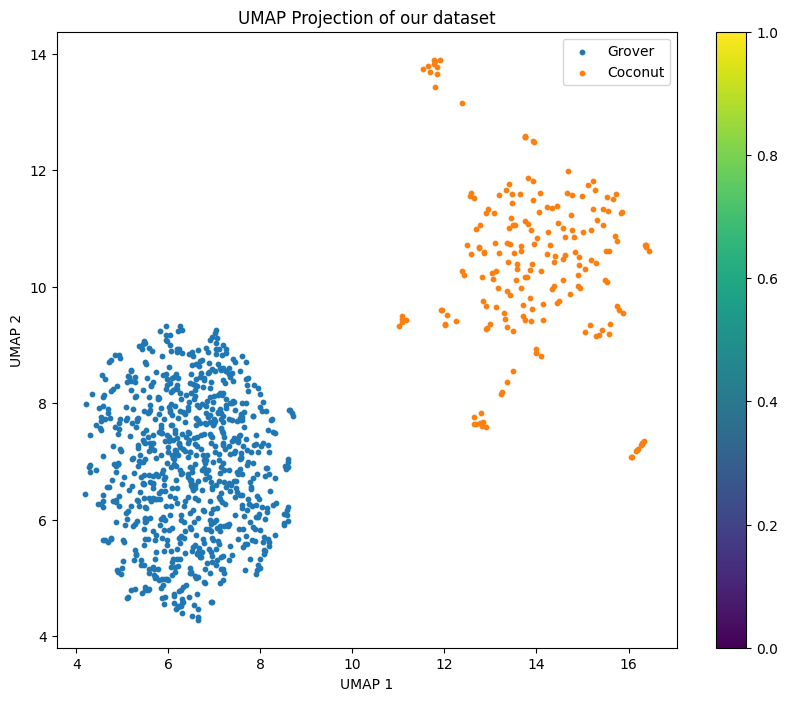

In [23]:
# Separate the data points based on the 'Data' column
grover_indices = combined_df.index[combined_df['Data'] == 'Grover']
coconut_indices = combined_df.index[combined_df['Data'] == 'Coconut']

# Filter the list of Morgan fingerprints based on the indices
grover_fps_train = [morgan_fps_train[i] for i in grover_indices]
coconut_fps_train = [morgan_fps_train[i] for i in coconut_indices]

# Reduce the dimensionality of the fingerprints to 2D using UMAP
reducer = umap.UMAP()
embedding_grover = reducer.fit_transform(grover_fps_train)
embedding_coconut = reducer.fit_transform(coconut_fps_train)

# Plot the UMAP embeddings with different colors for each dataset
plt.figure(figsize=(10, 8))
plt.scatter(embedding_grover[:, 0], embedding_grover[:, 1], s=10, cmap='viridis', label='Grover')
plt.scatter(embedding_coconut[:, 0], embedding_coconut[:, 1], s=10, cmap='magma', label='Coconut')
plt.title('UMAP Projection of our dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.legend()
plt.show()

/tmp/ipykernel_933/2202931973.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_grover[:, 0], embedding_grover[:, 1], s=10, cmap='viridis', label='Grover')
/tmp/ipykernel_933/2202931973.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding_coconut[:, 0], embedding_coconut[:, 1], s=10, cmap='magma', label='Coconut')


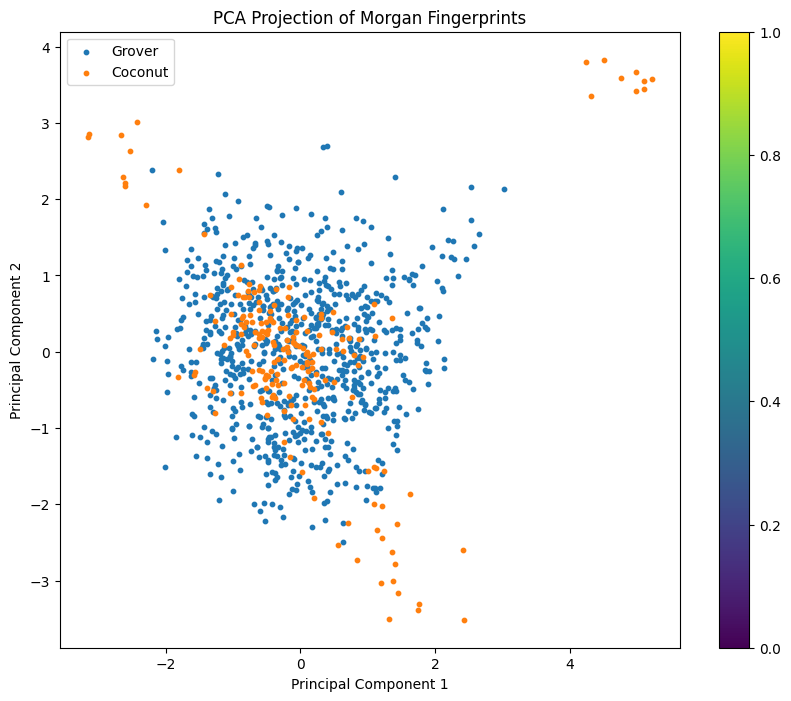

In [24]:
# Separate the data points based on the 'Data' column
grover_indices = combined_df.index[combined_df['Data'] == 'Grover']
coconut_indices = combined_df.index[combined_df['Data'] == 'Coconut']

# Filter the list of Morgan fingerprints based on the indices
grover_fps_train = [morgan_fps_train[i] for i in grover_indices]
coconut_fps_train = [morgan_fps_train[i] for i in coconut_indices]

# Reduce the dimensionality of the fingerprints to 2D using PCA
pca = PCA(n_components=2)
embedding_grover = pca.fit_transform(grover_fps_train)
embedding_coconut = pca.fit_transform(coconut_fps_train)

# Plot the PCA embeddings with different colors for each dataset
plt.figure(figsize=(10, 8))
plt.scatter(embedding_grover[:, 0], embedding_grover[:, 1], s=10, cmap='viridis', label='Grover')
plt.scatter(embedding_coconut[:, 0], embedding_coconut[:, 1], s=10, cmap='magma', label='Coconut')
plt.title('PCA Projection of Morgan Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.legend()
plt.show()